In [18]:
import os
import glob
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from python_speech_features import mfcc
from sklearn.preprocessing import StandardScaler
from scipy.signal import lfilter

# Filename identifiers

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

* Vocal channel (01 = speech, 02 = song).

* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

* Repetition (01 = 1st repetition, 02 = 2nd repetition).

* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

In [19]:
emotion_labels = {
    "01": 'neutral',
    "02": 'calm',
    "03": 'happy',
    "04": 'sad',
    "05": 'angry',
    "06": 'fearful',
    "07": 'disgust',
    "08": 'surprised'
}

allowed_emotions = ['happy', 'sad', 'angry', 'surprised']

def load_data(dataset_path):
    emotions = []
    features = []
    for file in glob.glob(dataset_path + 'Actor_*/*.wav'):
        emotion = extract_emotion_from_filename(os.path.basename(file))
        #if emotion not in allowed_emotions:
        #    continue
        emotions.append(emotion)
        features.append(extract_features(file))
    return np.array(features), np.array(emotions)

def extract_mfcc(audio, sample_rate):
    frame_len = int(2 ** np.floor(np.log2(0.03 * sample_rate)))
    mfccs = mfcc(audio, 
                 sample_rate, 
                 winlen=frame_len / sample_rate, 
                 winstep=frame_len / (2 * sample_rate), 
                 preemph=0.97,
                 numcep=12,
                 winfunc=np.hamming)
    return np.mean(mfccs, axis=0)

def extract_emotion_from_filename(filename):
    emotion_code = filename.split('-')[2]
    return emotion_labels[emotion_code]

def pre_emphasize(audio, alpha=0.97):
    return lfilter([1, -alpha], 1, audio)

def get_stft(audio):
    return np.abs(librosa.stft(audio))

def get_mffc(audio, sample_rate):
    return np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40, window=np.hamming).T,axis=0)

def get_chroma(stft, sample_rate):
    return np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)

def get_mel(audio, sample_rate):
    return np.mean(librosa.feature.melspectrogram(y=audio, sr=sample_rate).T,axis=0)

def extract_features(file_path):
    audio, sample_rate = librosa.load(file_path, duration=2.5, offset=0.6)
    
    # add filter
    audio = pre_emphasize(audio)

    # stft for chroma features
    stft = get_stft(audio)

    result = np.array([])

    mfccs = get_mffc(audio, sample_rate)
    result = np.hstack((result, mfccs))

    chroma = get_chroma(stft, sample_rate)
    result = np.hstack((result, chroma))

    mel = get_mel(audio, sample_rate)
    result = np.hstack((result, mel))
    
    return result

In [20]:
dataset_path = 'ravdess/'
features, emotions = load_data(dataset_path)

In [21]:
from sklearn.decomposition import PCA

scaler = StandardScaler()
stand_features = scaler.fit_transform(features)

#pca = PCA(n_components=0.95)
#stand_features = pca.fit_transform(features)

X_train, X_temp, y_train, y_temp = train_test_split(stand_features, emotions, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f'{len(X_train)} samples in training set')
print(f'{len(X_val)} samples in validation set')
print(f'{len(X_test)} samples in testing set')

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'linear']
}

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
}

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search_svm = GridSearchCV(SVC(), param_grid, refit=True, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_svm.fit(X_train, y_train)

grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid=param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train, y_train)


grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_knn.fit(X_train, y_train)

best_svm = grid_search_svm.best_estimator_
best_rf = grid_search_rf.best_estimator_
best_knn = grid_search_knn.best_estimator_

# combine training and validation
X_train_val = np.concatenate((X_train, X_val))
y_train_val = np.concatenate((y_train, y_val))

1152 samples in training set
144 samples in validation set
144 samples in testing set
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits


Results for SVM:
Testing Accuracy: 0.6875

Classification Report:
               precision    recall  f1-score   support

       angry       0.70      0.88      0.78        24
        calm       0.60      0.82      0.69        22
     disgust       0.73      0.80      0.76        20
     fearful       0.88      0.58      0.70        12
       happy       0.47      0.57      0.52        14
     neutral       0.50      0.44      0.47         9
         sad       0.80      0.57      0.67        21
   surprised       0.93      0.59      0.72        22

    accuracy                           0.69       144
   macro avg       0.70      0.66      0.66       144
weighted avg       0.72      0.69      0.69       144

Confusion Matrix:


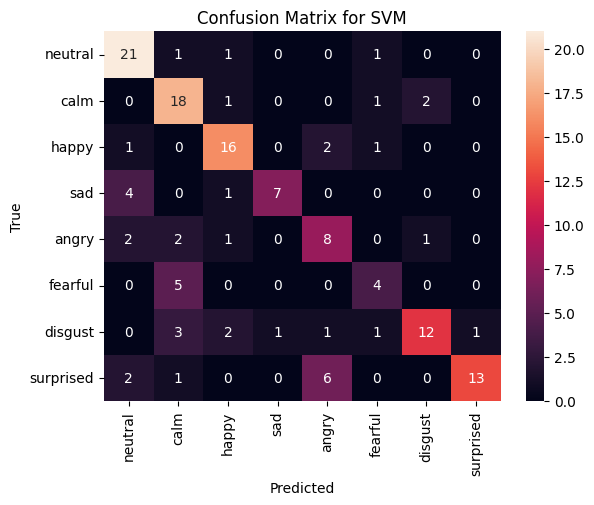

Results for Random forest:
Testing Accuracy: 0.5347222222222222

Classification Report:
               precision    recall  f1-score   support

       angry       0.80      0.67      0.73        24
        calm       0.53      0.91      0.67        22
     disgust       0.37      0.50      0.43        20
     fearful       0.57      0.67      0.62        12
       happy       0.25      0.21      0.23        14
     neutral       0.25      0.11      0.15         9
         sad       0.67      0.38      0.48        21
   surprised       0.65      0.50      0.56        22

    accuracy                           0.53       144
   macro avg       0.51      0.49      0.48       144
weighted avg       0.55      0.53      0.52       144

Confusion Matrix:


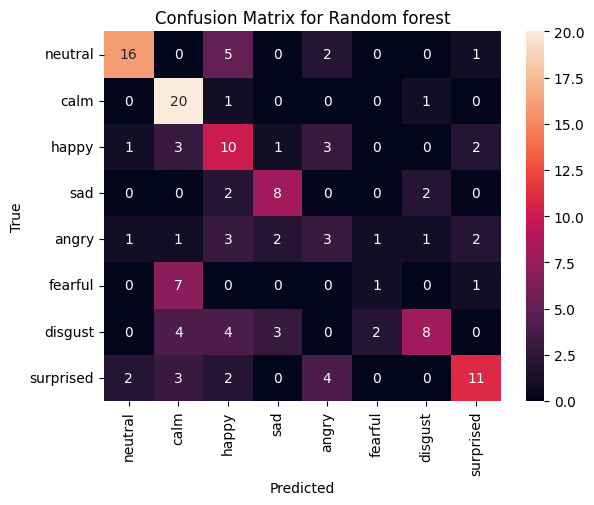

Results for KNN:
Testing Accuracy: 0.6597222222222222

Classification Report:
               precision    recall  f1-score   support

       angry       1.00      0.75      0.86        24
        calm       0.67      0.73      0.70        22
     disgust       0.79      0.75      0.77        20
     fearful       0.64      0.58      0.61        12
       happy       0.54      0.50      0.52        14
     neutral       0.31      0.56      0.40         9
         sad       0.57      0.57      0.57        21
   surprised       0.68      0.68      0.68        22

    accuracy                           0.66       144
   macro avg       0.65      0.64      0.64       144
weighted avg       0.69      0.66      0.67       144

Confusion Matrix:


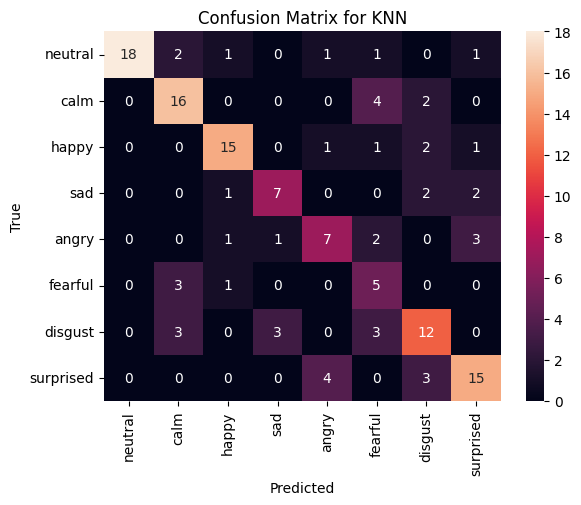

In [23]:
classifiers = {
    'SVM': best_svm,
    'Random forest': best_rf,
    'KNN': best_knn
}

def result_helper(name, y_test, y_pred):
    emotion_labels_list = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
    print(f"Results for {name}:")
    print(f"Testing Accuracy: {accuracy_score(y_test, y_pred)}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', xticklabels=emotion_labels_list, yticklabels=emotion_labels_list)
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

for name, clf in classifiers.items():
    clf.fit(X_train_val, y_train_val)
    y_pred_train = clf.predict(X_train_val)
    y_pred = clf.predict(X_test)
    result_helper(name, y_test, y_pred)